# TSMC 隔日股價漲、跌 監督式學習分類模型分析比較與評估
This notebook demonstrates the process of training and comparing three classification models (Logistic Regression, Random Forest, XGBoost) to predict next-day price movement of TSMC.

修改項目：
- 修改下載資料結構，浮點數至小數第二位
- 取消畫盒鬚圖、常態分佈圖使用正規化之數據
- 產生新技術指標的浮點數至小數第二位
- 取消 tsmc2330-2.csv 檔案
- 熱力圖使用 tsmc2330-1.csv 檔案計算
- Lag1_Return, Volume_change 增加 inf, -inf 無限大處理機制
- BB band 計算公式修正
- 資料分割後針對 X_train, X_test 做 RobustScaler 正規化
- Logistic Regression 參數最佳化 （penalty='l2', C=0.1, solver='lbfgs', max_iter=1000）
- 修正 Feature importance 圖表 8 個特徵減為6個特徵的問題

In [1]:
# Used packages for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta import add_all_ta_features
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


#### 由yFinance API 下載 TSMC 2330 歷史股價資料與資料預處理

In [2]:
import yfinance as yf
import pandas as pd

# Step 1: Download data (single ticker, no group_by)
data = yf.download(
    "2330.TW",
    start="2020-01-01",
    end="2025-06-03",
    interval="1d",
    auto_adjust=True
)

# Step 2: Reset index to include 'Date' as a column
data.reset_index(inplace=True)

# Step 3: If multi-level columns exist, flatten them
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [' '.join(col).strip() for col in data.columns.values]

# Step 4: Rename columns to exactly what you want
rename_map = {}
for col in data.columns:
    if "Open" in col: rename_map[col] = "Open"
    if "High" in col: rename_map[col] = "High"
    if "Low" in col: rename_map[col] = "Low"
    if "Close" in col and "Adj" not in col: rename_map[col] = "Close"
    if "Volume" in col: rename_map[col] = "Volume"
    if "Date" in col: rename_map[col] = "Date"
data.rename(columns=rename_map, inplace=True)

# Step 5: Keep only the desired columns
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Step 6: Format numbers
data[['Open', 'High', 'Low', 'Close']] = data[['Open', 'High', 'Low', 'Close']].round(2)
data['Volume'] = data['Volume'].astype(int)

# ✅ Step 7: Export clean CSV (no hidden header rows!)
data.to_csv("tsmc2330.csv", index=False, encoding="utf-8-sig")


[*********************100%***********************]  1 of 1 completed


##### 特徵工程：加入技術指標 (MA5, MA10, MA20, RSI, BB band_upper, BB band_lower.), 
##### 將Return欄 漲、跌欄位標準化改為 0(跌、平盤), 1(漲)，並放在最後一欄 Target 做為目標值

In [3]:
import pandas as pd
import numpy as np

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(price, slow=26, fast=12, signal=9):
    ema_fast = price.ewm(span=fast).mean()
    ema_slow = price.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    return macd.round(2), signal_line.round(2)

def compute_bollinger_bands(price, window=20, num_std=2):
    ma = price.rolling(window=window).mean()
    std = price.rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    return upper_band.round(2), lower_band.round(2)


# 1. 讀取資料
df = pd.read_csv("tsmc2330.csv")

# 2. 新增技術指標
df["Return"] = (df["Close"].pct_change()*100).round(2)
df["MA5"] = (df["Close"].rolling(window=5).mean()).round(2)
df["MA10"] = (df["Close"].rolling(window=10).mean()).round(2)
df["MA20"] = (df["Close"].rolling(window=20).mean()).round(2)
df["Price_Change"] = (df["Close"] - df["Open"]).round(2)

# RSI
df["RSI"] = (compute_rsi(df["Close"])).round(2)

# MACD & Signal Line
df["MACD"], df["MACD_Signal"] = compute_macd(df["Close"])

# Bollinger Bands
df["BB_Upper"], df["BB_Lower"] = compute_bollinger_bands(df["Close"])

# 3. 處理漲跌目標欄位
#df["Increase"] = df["Increase"].str.replace("%", "").astype(float)
#標準化 "return" 成為Target 欄位: -1 (跌) 0 (漲), 1 (漲)
df["Target"] = df['Return'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 0))

# 移除缺失值
df.dropna(inplace=True)
#df.head()


df.to_csv('tsmc2330-1.csv', index = False)

#### 讀取資料

In [4]:
# 🔹 讀取資料
df = pd.read_csv("tsmc2330-1.csv")
#df["Date"] = pd.to_datetime(df["Date"])
#df = df.sort_values("Date")
df.head()

,Date,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
0,2020-02-07,305.25,305.71,301.55,303.40,28798327,-1.35,301.18,302.01,307.05,-1.85,43.07,-1.54,-1.47,322.48,291.62,0
1,2020-02-10,297.38,303.40,296.92,302.93,30632424,-0.15,303.49,301.36,306.52,5.55,41.05,-1.45,-1.46,321.73,291.30,0
2,2020-02-11,305.71,307.56,305.25,306.63,27524935,1.22,304.69,301.22,306.15,0.92,42.76,-1.12,-1.39,320.95,291.35,1
3,2020-02-12,308.48,310.80,308.02,309.87,37612639,1.06,306.08,301.41,306.29,1.39,41.91,-0.63,-1.24,321.17,291.40,1
4,2020-02-13,312.65,312.65,309.87,309.87,22757021,0.00,306.54,303.12,306.54,-2.78,45.96,-0.23,-1.04,321.49,291.59,0


In [70]:
features = df.drop(columns=["Date", "Target"])  # 特徵值不包含 日期 及 Target 欄位
X = features
y = df["Target"]  #設定目標值在 Target 欄位

#### 敘述統計

In [5]:
df.describe()

,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
count,1292.000000,1292.000000,1292.000000,1292.000000,1.292000e+03,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000
mean,606.879814,611.423630,601.904474,606.591842,3.642305e+07,0.104721,605.577438,604.271169,601.683785,-0.287972,53.389358,3.471246,3.417608,638.464946,564.902740,0.486068
std,215.831413,217.893264,214.016049,215.854475,2.091602e+07,1.890252,215.458765,215.007388,213.998774,7.224560,16.737809,12.979081,12.210104,228.785278,200.958594,0.499999
min,235.360000,236.290000,219.950000,231.620000,0.000000e+00,-9.980000,242.070000,248.520000,254.500000,-37.000000,6.670000,-48.960000,-40.770000,273.400000,223.900000,0.000000
25%,484.975000,488.770000,481.290000,484.642500,2.250091e+07,-0.932500,484.012500,483.205000,477.712500,-3.890000,41.080000,-3.230000,-3.075000,512.072500,449.987500,0.000000
50%,561.000000,563.960000,556.380000,560.120000,3.194742e+07,0.000000,560.970000,561.890000,563.105000,0.000000,52.600000,2.630000,2.575000,585.905000,532.905000,0.000000
75%,635.230000,641.070000,629.382500,639.062500,4.325209e+07,1.100000,636.227500,634.017500,625.412500,2.962500,65.417500,10.495000,10.230000,660.520000,589.160000,1.000000
max,1150.000000,1160.000000,1135.000000,1135.000000,1.663077e+08,9.980000,1120.000000,1111.500000,1106.000000,41.000000,100.000000,43.950000,39.610000,1147.140000,1066.990000,1.000000


使用 Prof. J.W.Tukey 在1977年於Exploratory data analysis 所發表的方式計算 tsmc2330-1.csv 各欄的盒鬚圖及長條圖的常態分佈圖、Q-Q plot. ("Date", "Target" 2欄不用畫圖) 觀察資料離群及常態分布狀態

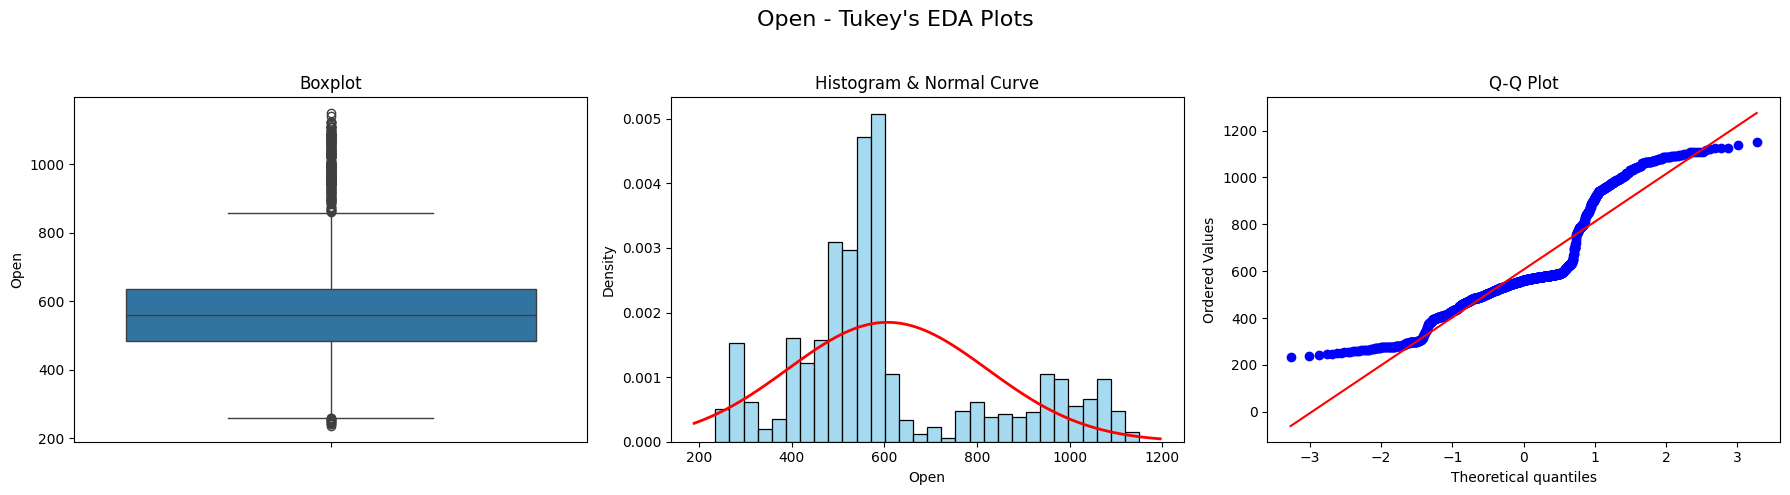

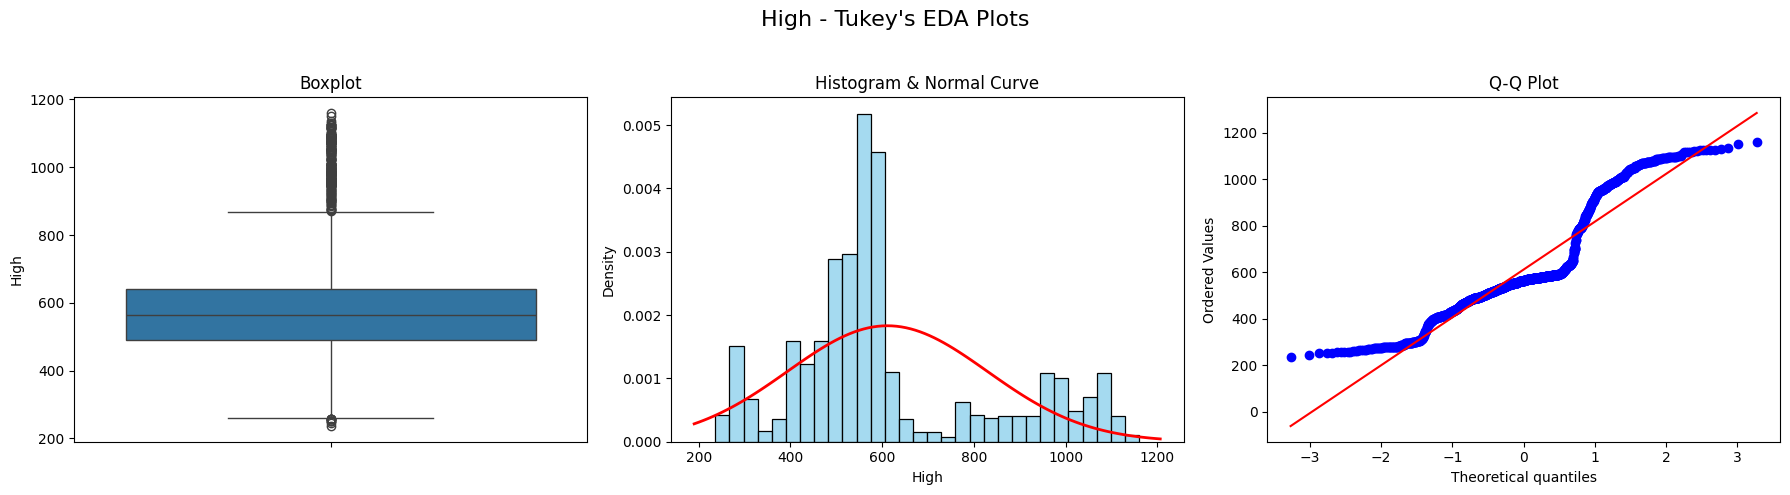

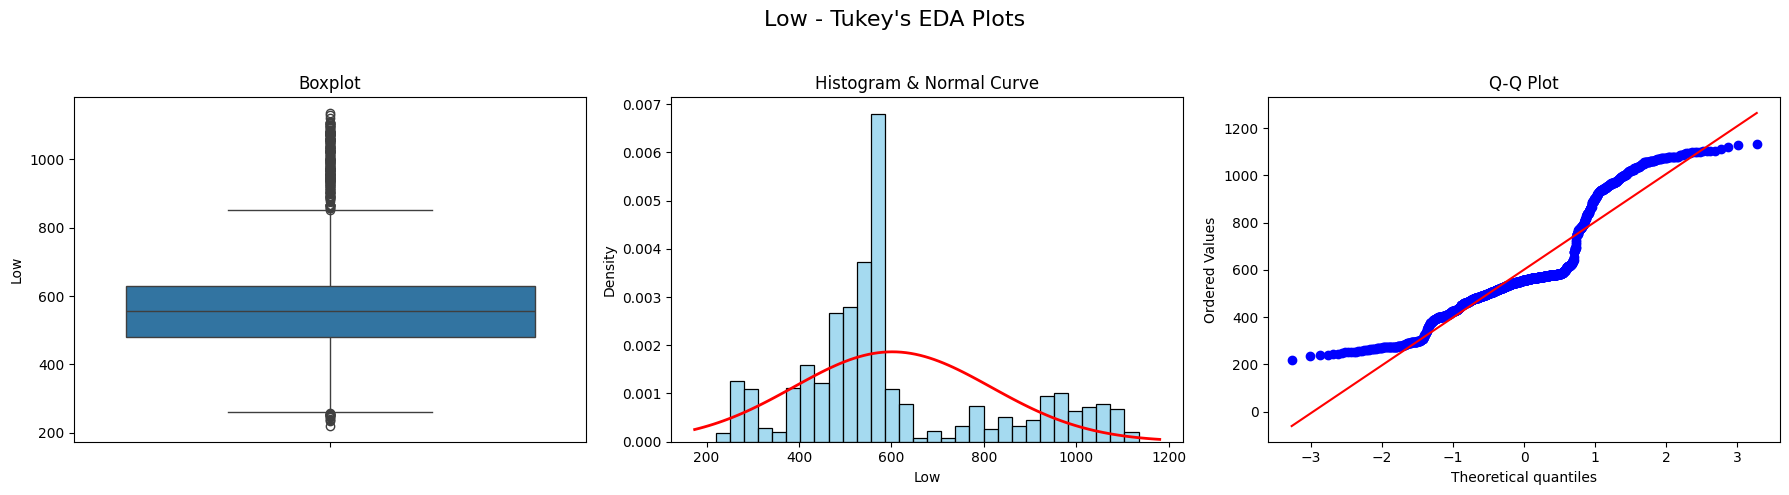

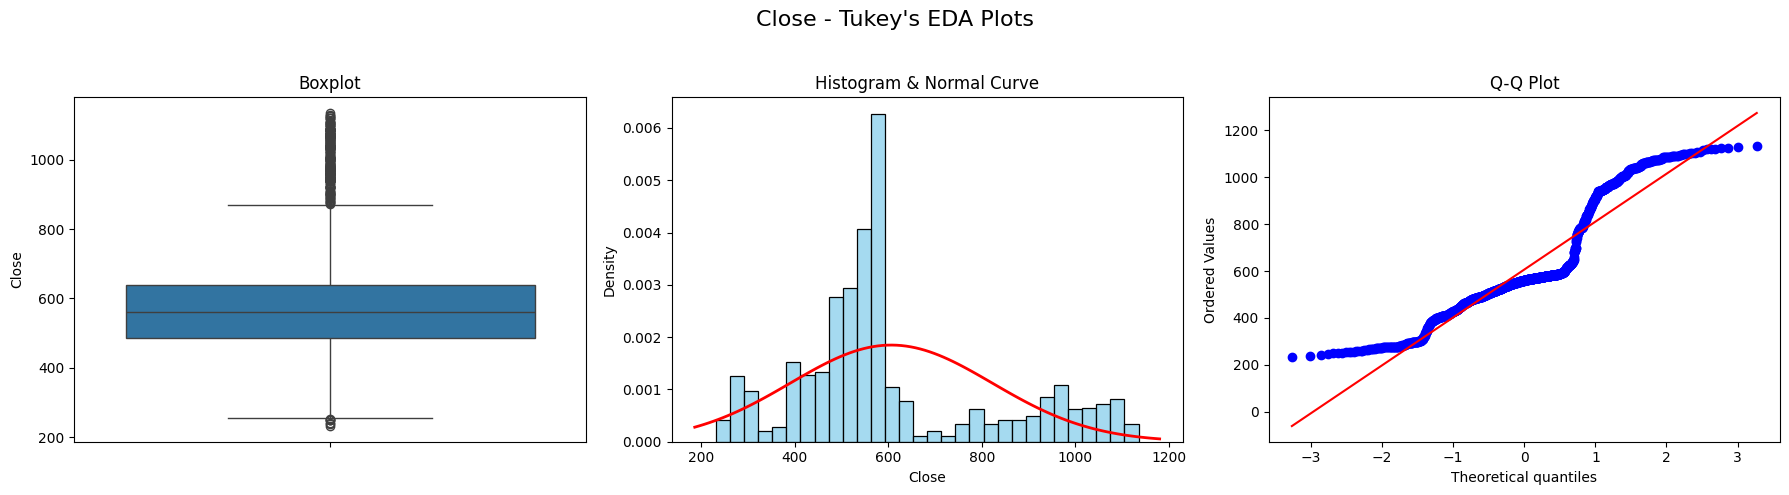

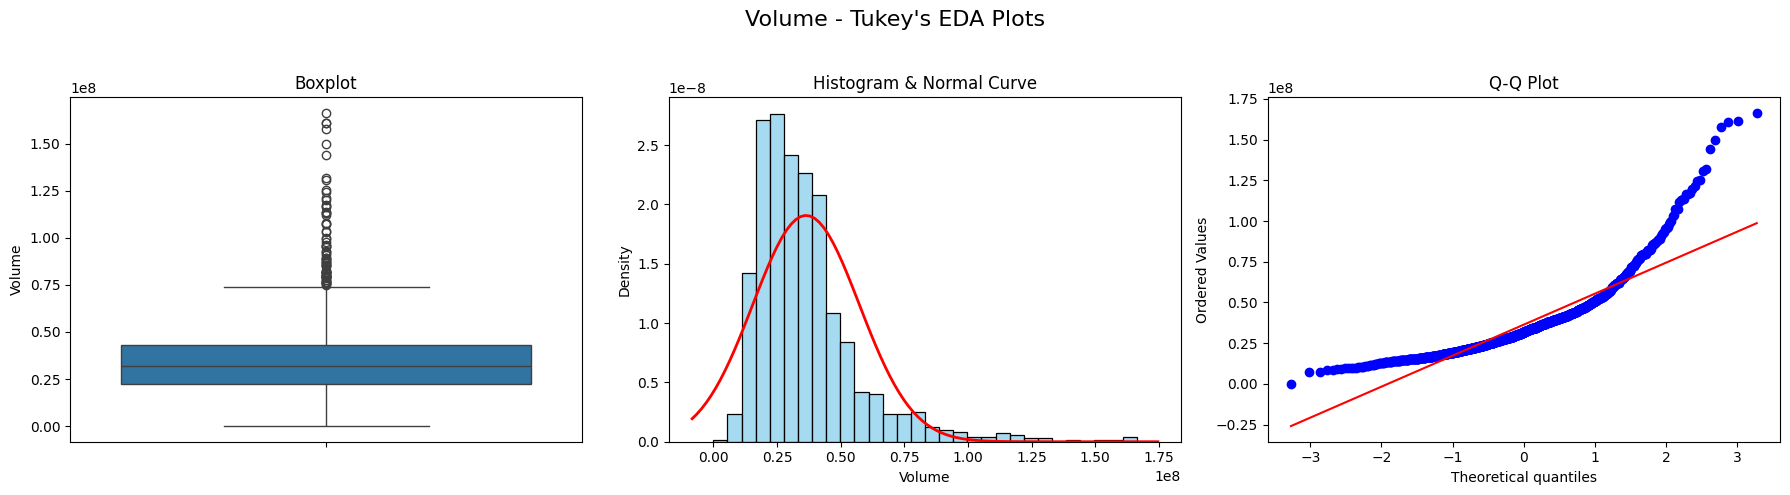

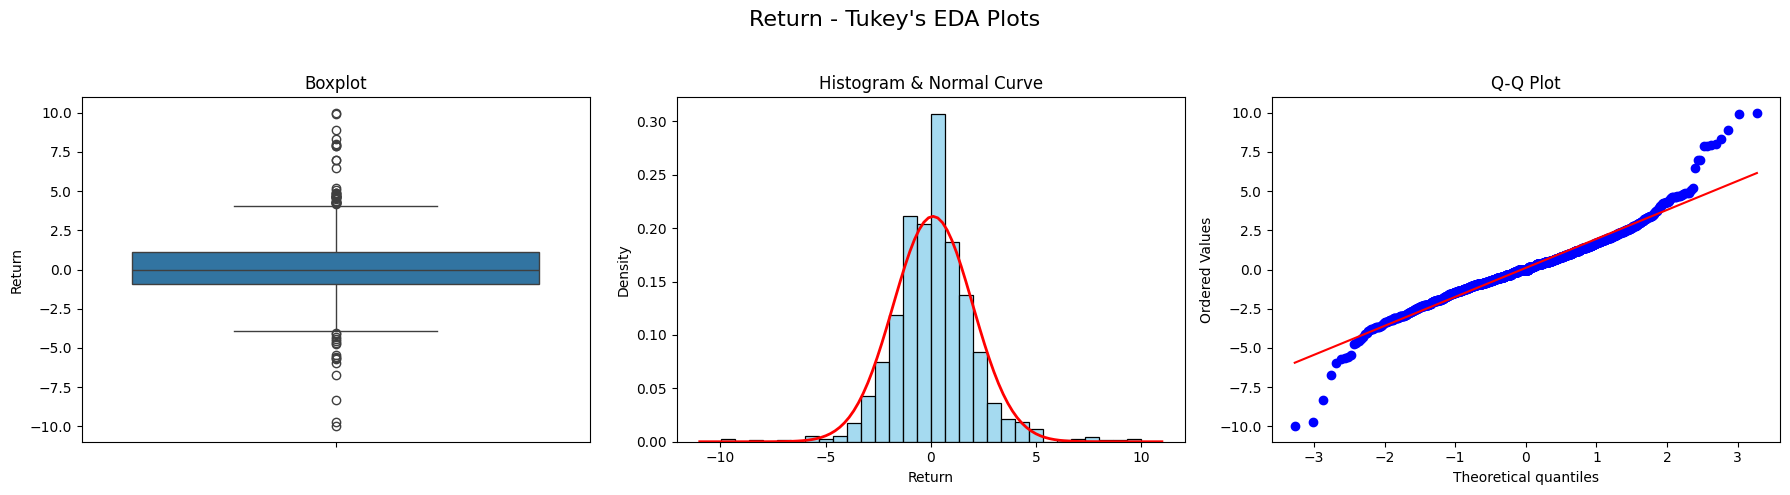

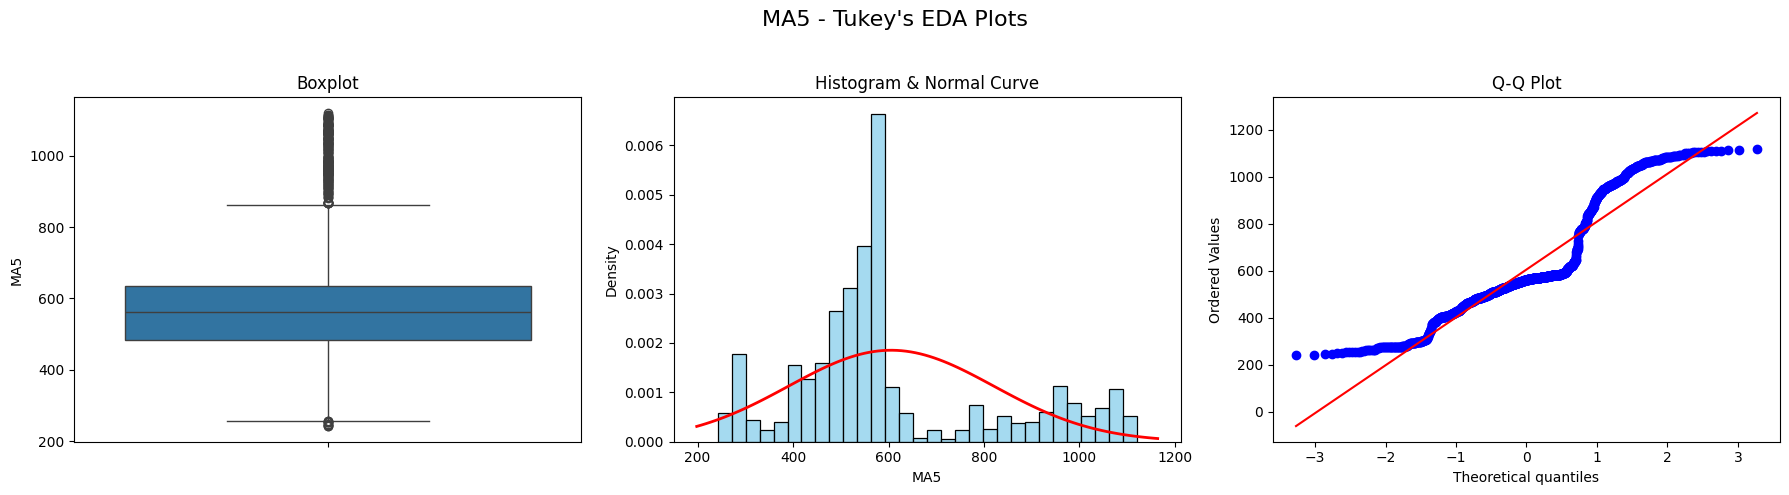

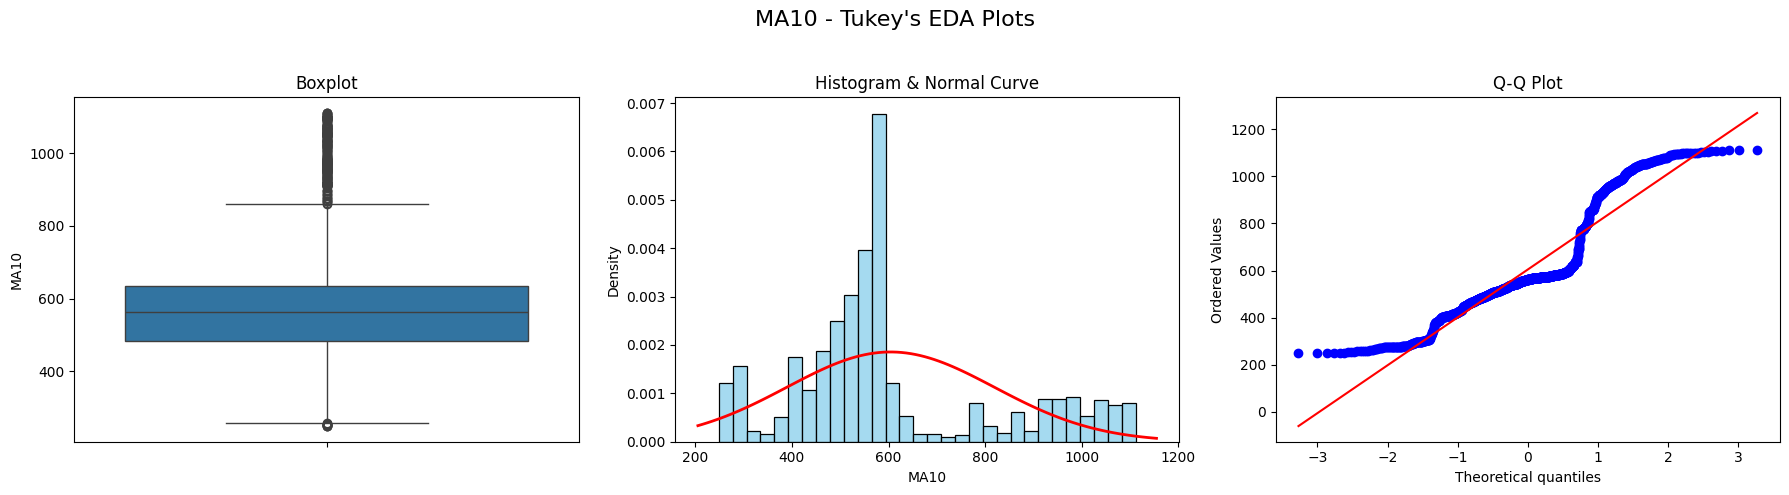

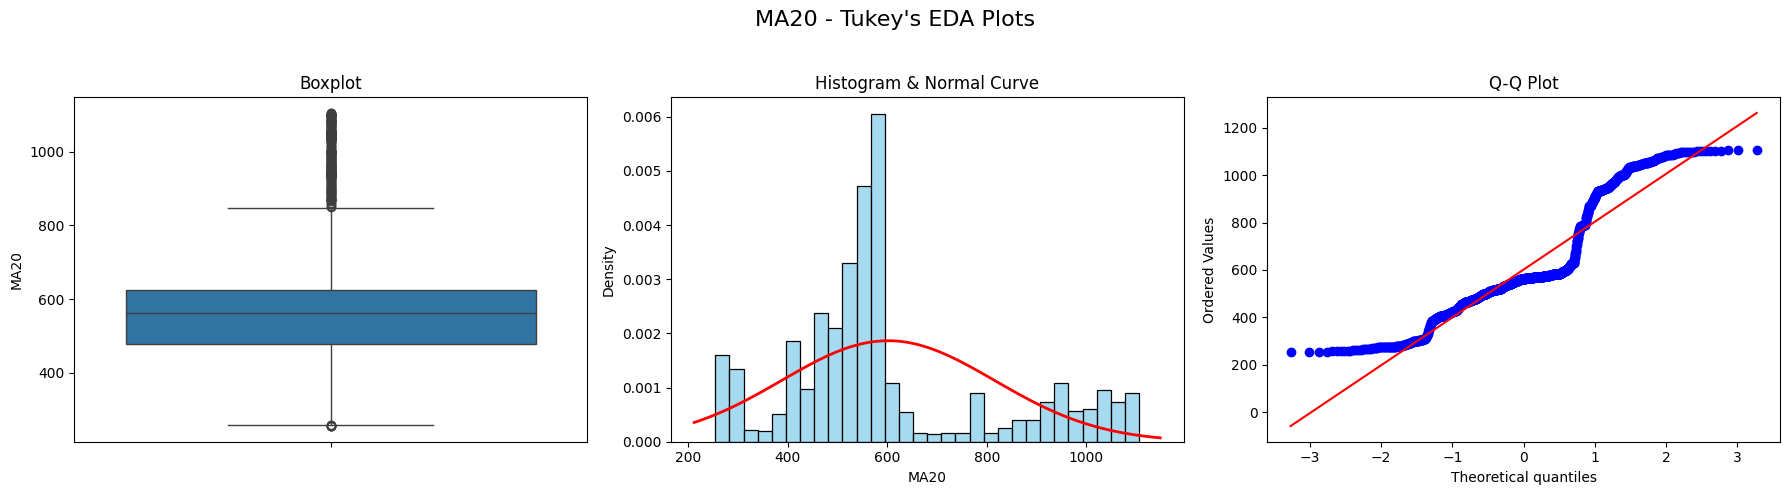

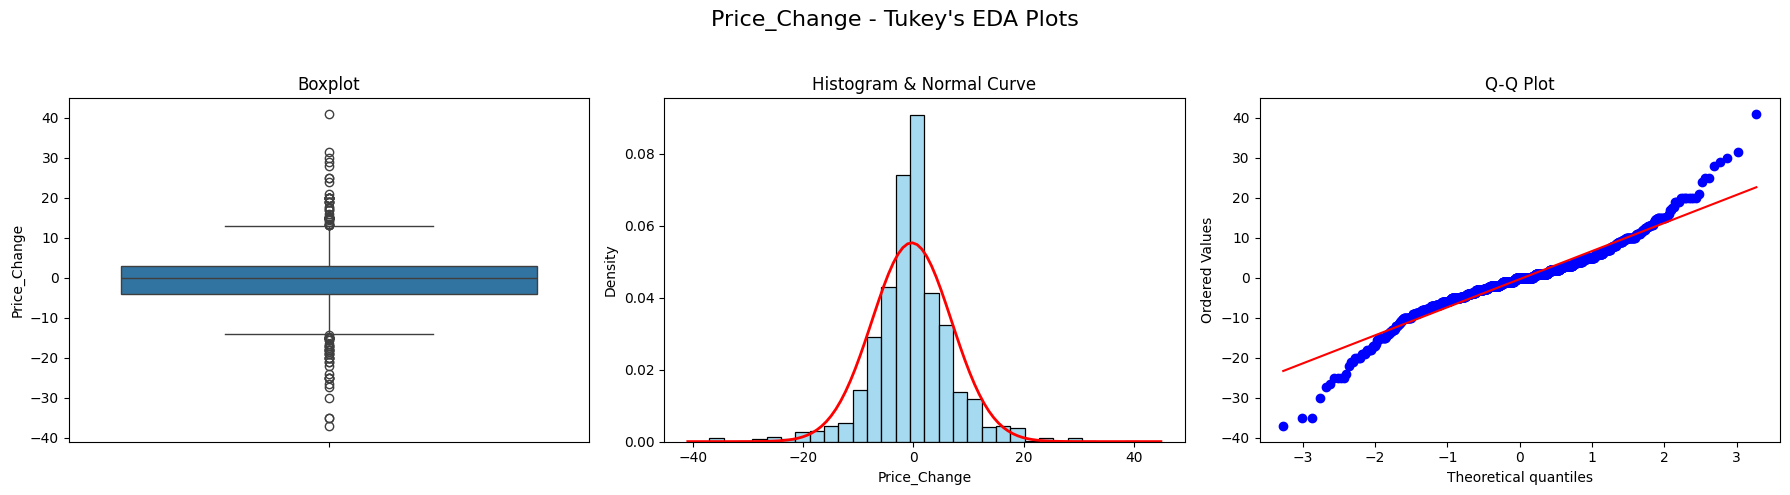

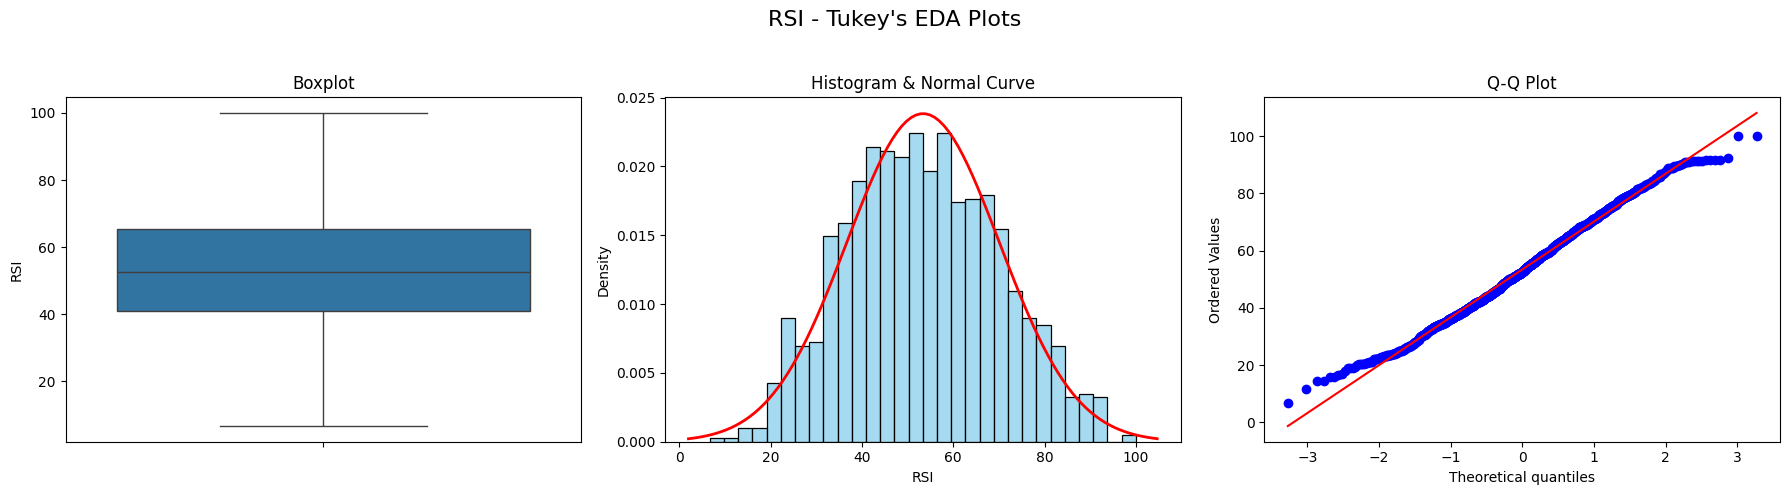

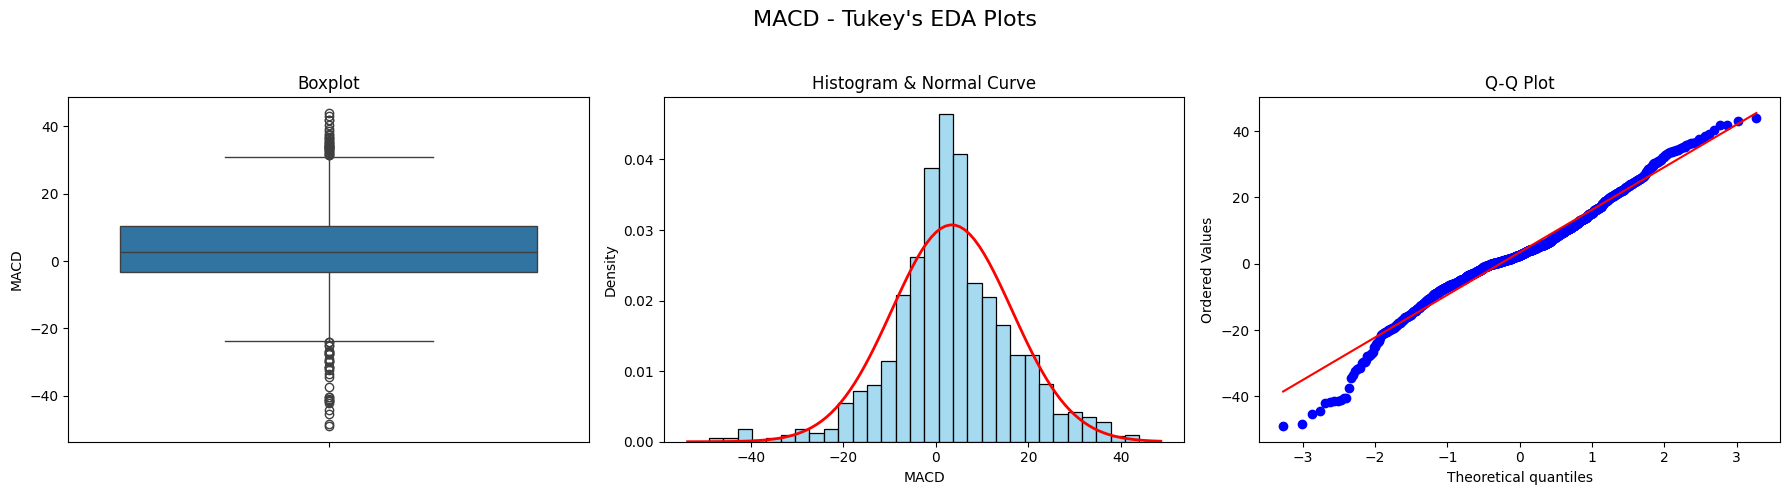

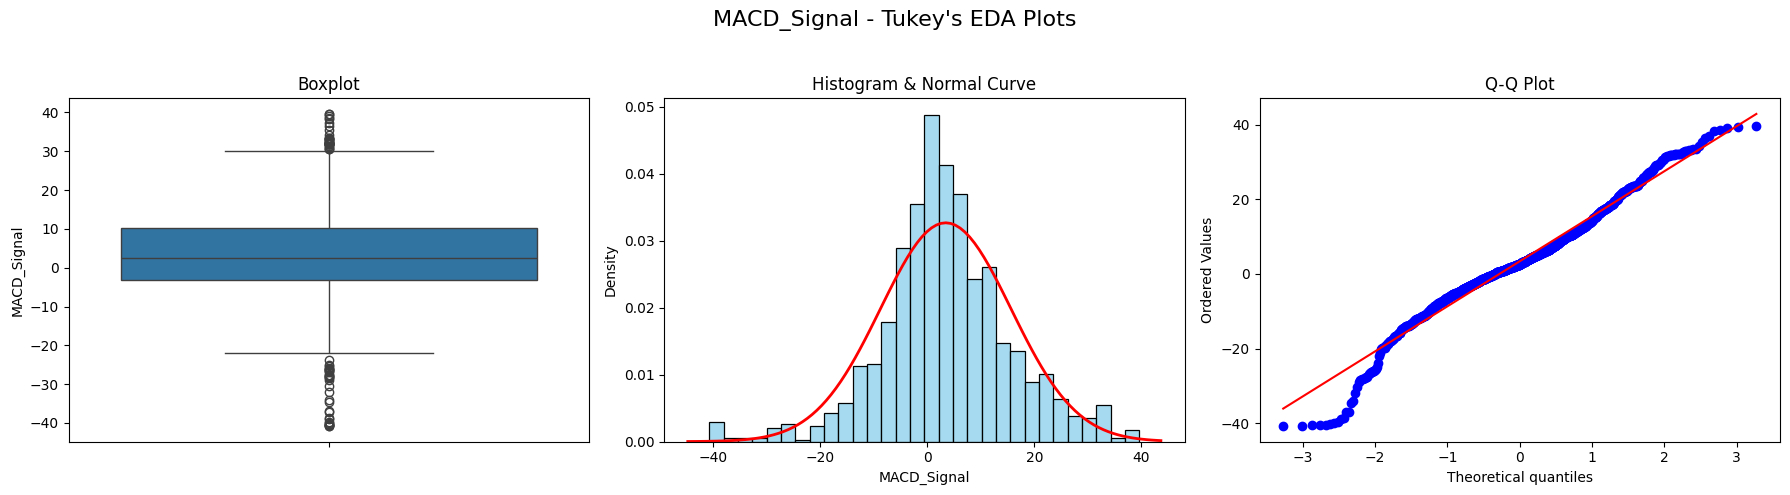

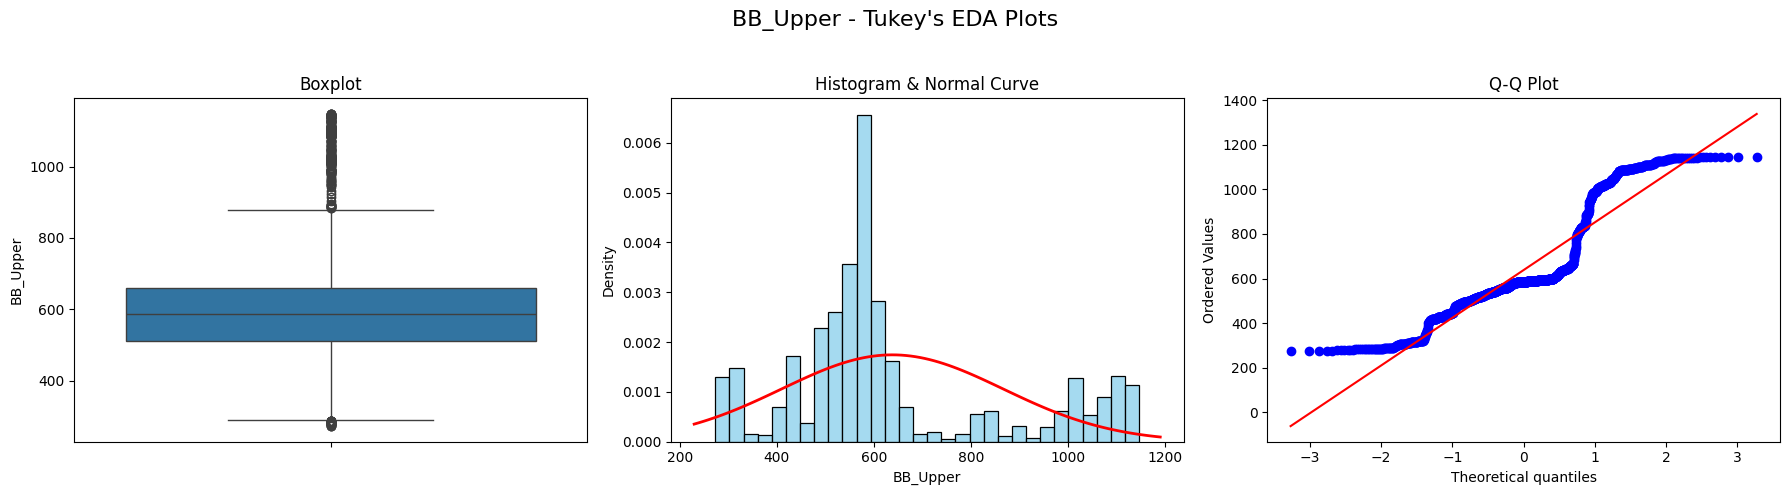

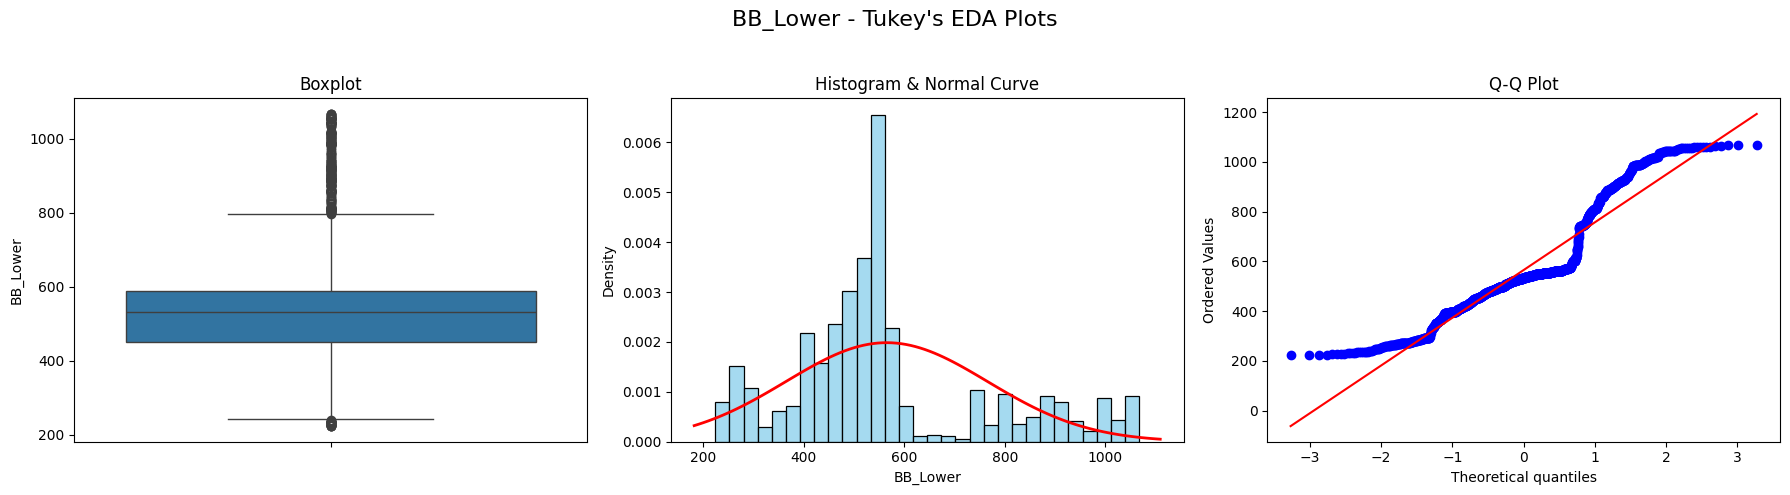

In [6]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取增加技術指標後的資料
df = pd.read_csv("tsmc2330-1.csv")

# 需要繪圖的欄位
plot_cols = [col for col in df.columns if col not in ["Date", "Target"]]

for col in plot_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{col} - Tukey's EDA Plots", fontsize=16)
    
    # 盒鬚圖 (Boxplot)
    sns.boxplot(y=df[col], ax=axes[0])
    axes[0].set_title("Boxplot")
    
    # 長條圖及常態分佈圖 (Histogram + Normal Curve)
    sns.histplot(df[col], kde=False, stat="density", ax=axes[1], bins=30, color='skyblue')
    # 正態分佈曲線
    mu, std = df[col].mean(), df[col].std()
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[1].plot(x, p, 'r', linewidth=2)
    axes[1].set_title("Histogram & Normal Curve")
    
    # Q-Q plot
    stats.probplot(df[col], dist="norm", plot=axes[2])
    axes[2].set_title("Q-Q Plot")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])

### 特徵選擇：使用Pearson's correlation coefficient 分析特徵相關性

### tsmc2330-1.csv 熱力圖

In [7]:
#  選擇特徵變數分析
features_analysis = df.drop(columns=["Date"])

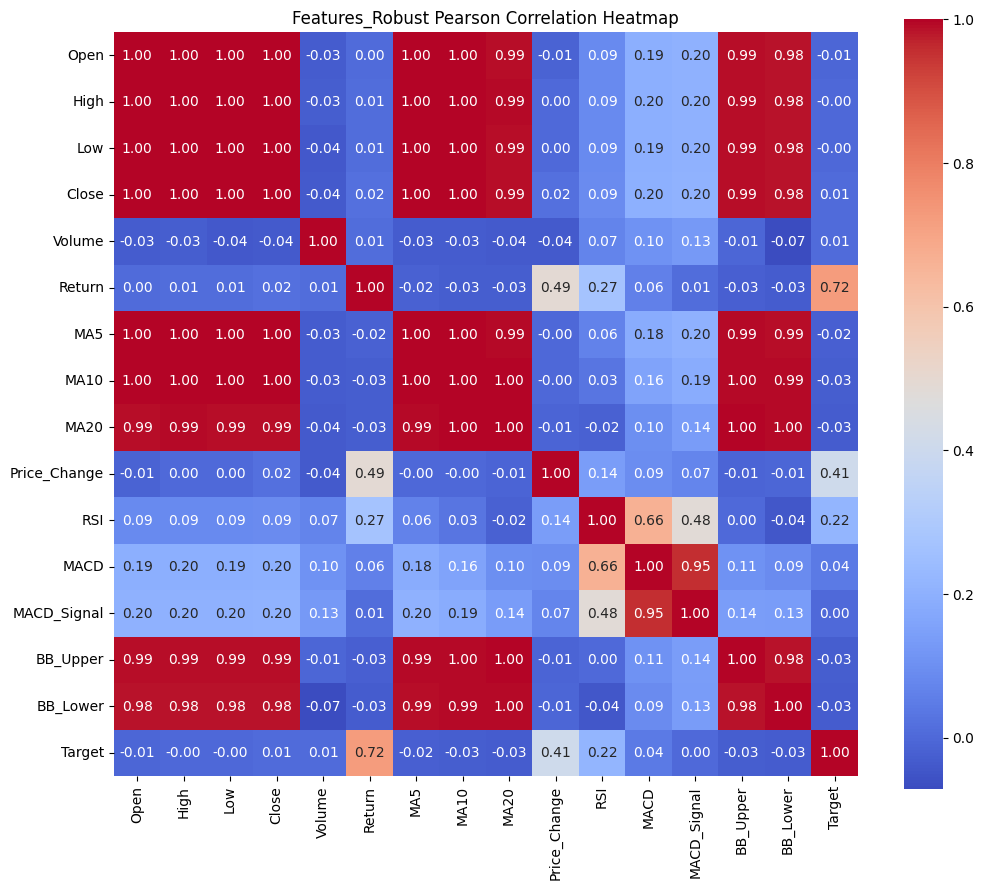

In [8]:
# 計算 Pearson's correlation coefficient
# features_robust =df_robust.drop(columns=["Column1", "Date"]) 上面已經有設定 feature_robust
corr_matrix = features_analysis.corr(method='pearson')

# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Features_Robust Pearson Correlation Heatmap")
plt.show()

### 由熱力圖分析 Pearson's corelation coefficient, 最相關的特徵，其相關係數如下:
- Return: 0.72
- Price change: 0.42
- RSI: 0.23
由熱力圖也觀察到有特徵重疊的情形

### 因為資料離群值比較多，另使用 Spearman 相關係數分析特徵變數相關性

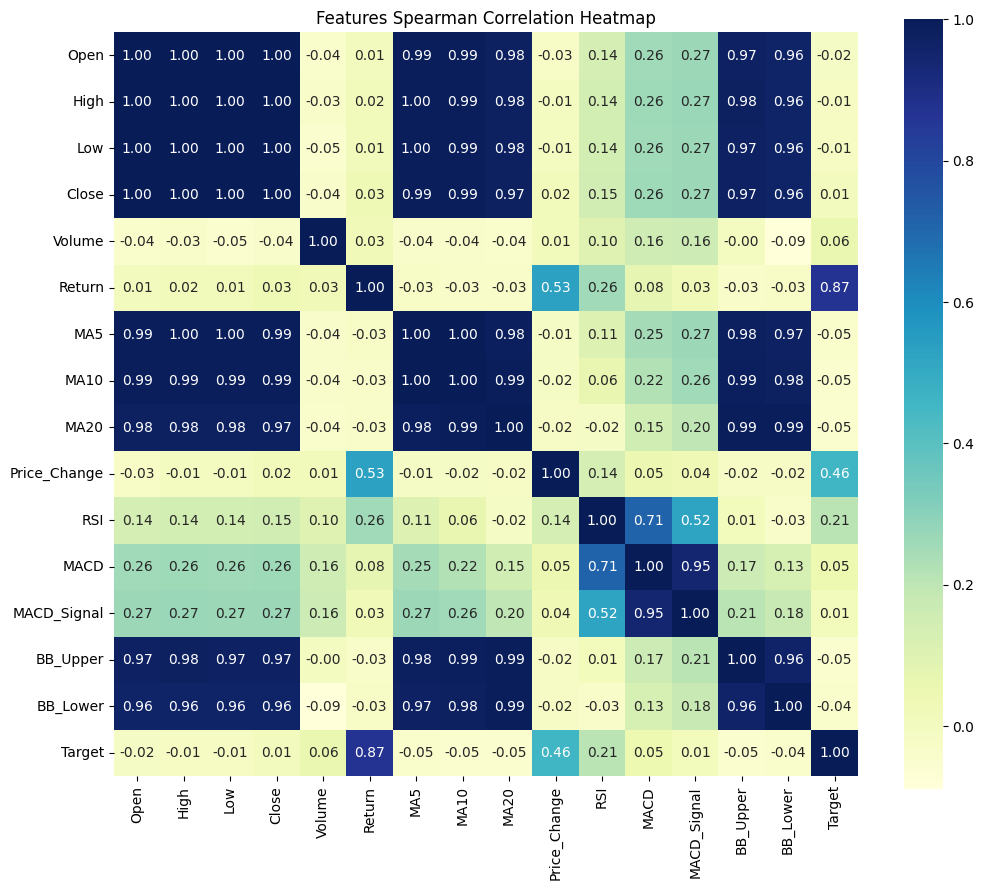

In [9]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df = pd.read_csv("tsmc2330-1.csv")

# Spearman 相關係數分析
#features_analysis = df_robust.drop(columns=["Date"])  使用上面的設定
corr_matrix_spearman = features_analysis.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_spearman, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Features Spearman Correlation Heatmap")
plt.show()

相關性高的特徵變數及其相關係數:
- Return: 0.89
- Price_Change: 0.47
- RSI: 0.22
由 Spearman 相關係數也觀察到特徵重疊的現象

由Pearson 相關係數發現open, high, low, close 區塊、MA5, MA10, MA20 區塊、BB_upper, BB_lower 區塊幾乎都是 1.00 呈現高度共線，表示這些特徵是重複資訊，需重新建構特徵。
其中，Return, Price_change, RSI 是比較高的係數，表示與 Target 相關。

另外的問題是 Return 的計算是使用（今日的收盤價 - 昨日的收盤價）/ 昨日的收盤價
Target 漲跌也是 今日的收盤價 - 昨日的收盤價，用這樣的方式預測結果會100% 準確，
需使用歷史資料來預測明天的漲跌，否則會有資料洩漏（data leakage) 的問題

#### 重新建構特徵、去空值、設定目標 y

In [10]:
# Load preprocessed data
df = pd.read_csv('tsmc2330-1.csv')

## Feature Engineering: Lagged Historical Features
df['Lag1_Close'] = df['Close'].shift(1)
df['Lag1_Return'] = df['Close'].pct_change().shift(1)
df.replace({'Lag1_Return': {np.inf: np.nan, -np.inf: np.nan}}, inplace=True)
df.fillna({'Lag1_Return': 0}, inplace=True)

df['Lag1_RSI'] = df['RSI'].shift(1)
df['Lag1_MACD'] = df['MACD'].shift(1)
df['Lag1_MACD_Signal'] = df['MACD_Signal'].shift(1)
df['Volume_Change'] = df['Volume'].pct_change().shift(1)
df.replace({'Volume_Change': {np.inf: np.nan, -np.inf: np.nan}}, inplace=True)
df.fillna({'Volume_Change': 0}, inplace=True)
df['MA5_diff'] = (df['MA5'].shift(1) - df['MA10'].shift(1)) / df['MA10'].shift(1)

bandwidth = df['BB_Upper'].shift(1) - df['BB_Lower'].shift(1)
df['BB_Pressure'] = (df['Close'].shift(1) - df['BB_Lower'].shift(1)) / bandwidth

features = ['Lag1_Close','Lag1_Return','Lag1_RSI','Lag1_MACD','Lag1_MACD_Signal','Volume_Change','MA5_diff','BB_Pressure']
#df_model = df.dropna()
df_model = df[features+['Target']].dropna()

X = df_model[features]
y = df_model['Target']
X.to_csv('X.csv')
y.to_csv('y.csv')

#### 重做 Pearson's 相關係數分析，卻認特徵沒有共線問題

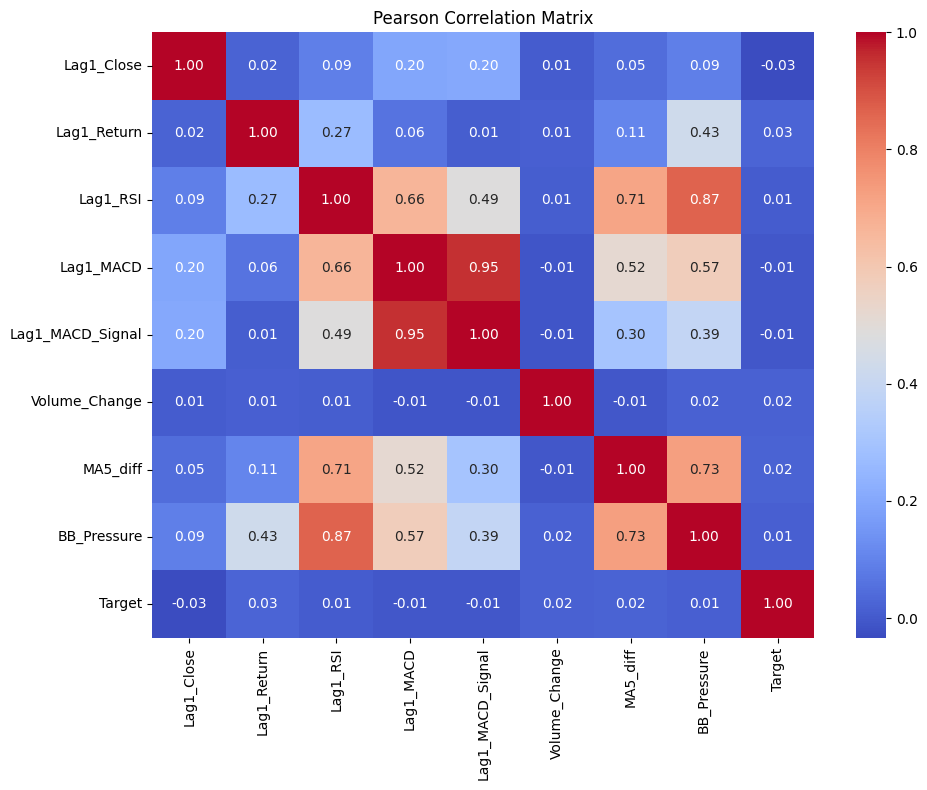

In [11]:
# Pearson Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.show()

從上面可看出 lag1_Close, lag1_RSI, lag1_MACD, lag1_MACD_Signal, MA5_diff, BB_Pressure 相關

#### 資料分割為訓練集(80%)與測試集(20%), 使用 42 號洗牌程序，確認數據分割的結果都完全一樣，讓實驗可以被重現。
#### 特徵正歸化使用 RobustScaler

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.to_csv('X_train.csv')
X_test = X_test[X_train.columns]
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 模型訓練及評估
1. 邏輯迴歸
2. 隨機森林
3. XGBoost

### Logistic Regression
Accuracy: 0.5560, Precision: 0.5379, Recall: 0.6190, F1-score: 0.5756, AUC: 0.5308



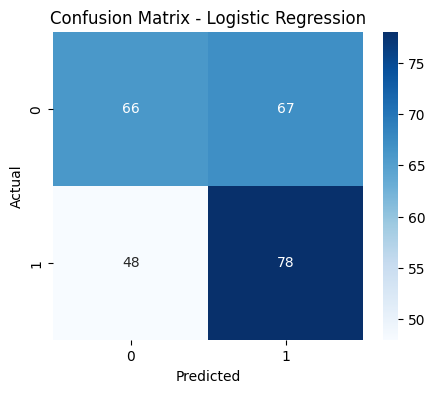

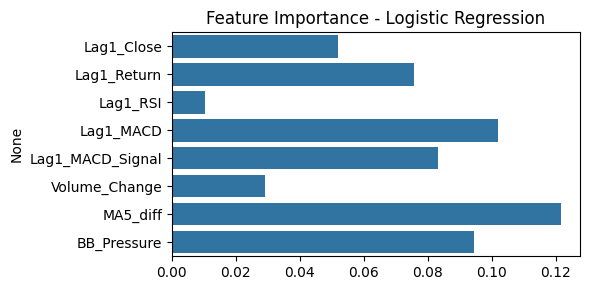

### Random Forest
Accuracy: 0.4710, Precision: 0.4610, Recall: 0.5159, F1-score: 0.4869, AUC: 0.4853



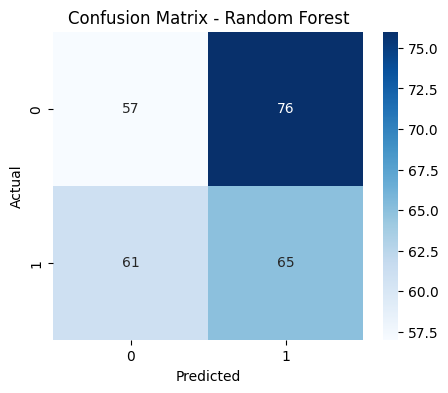

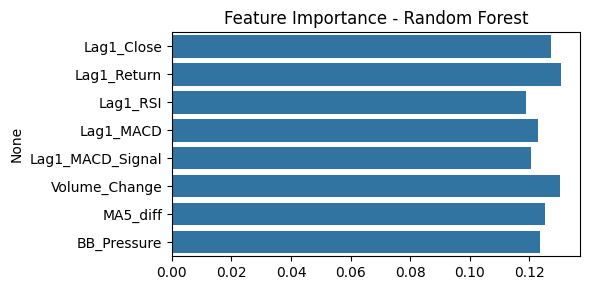

### XGBoost
Accuracy: 0.5367, Precision: 0.5227, Recall: 0.5476, F1-score: 0.5349, AUC: 0.5300



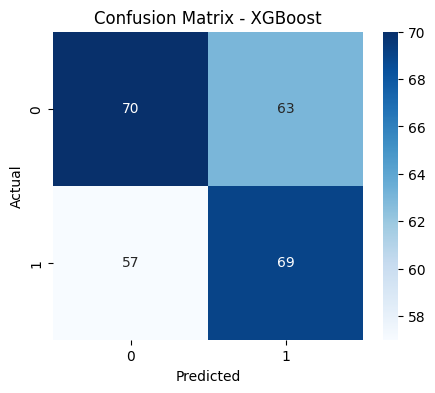

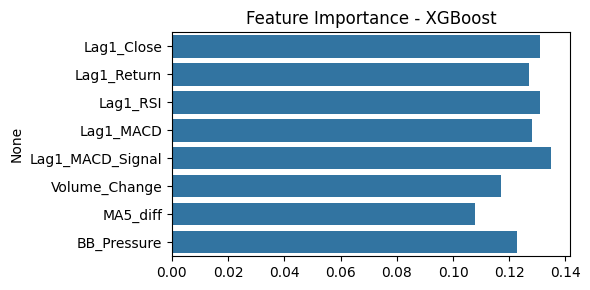

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=1000,class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"### {name}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}, AUC: {auc:.4f}\n")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Feature Importance
    features = X_train.columns
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    elif hasattr(model, 'coef_'):
        imp = np.abs(model.coef_[0])
    plt.figure(figsize=(6,3))
    sns.barplot(x=imp, y=features)
    plt.title(f'Feature Importance - {name}')
    plt.tight_layout()
    plt.show()
    # Store ROC for comparison
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    results[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

## ROC 曲線比較

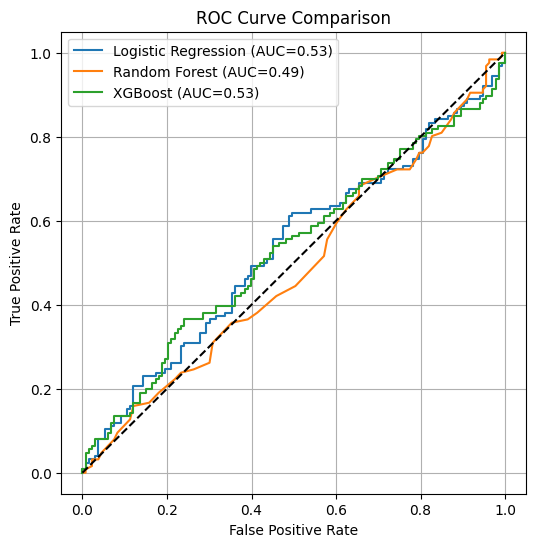

In [14]:
plt.figure(figsize=(6,6))
for name, res in results.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC={res['auc']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()